# NHANES Diabetes Prediction Model Pipeline

### By John Semerdjian and Spencer Frank

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('seaborn-white')
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Helper functions
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from nhanes.utils import (GridSearchCVWrapper, 
                          one_hot_encode, 
                          precision_recall_thershold, 
                          plot_recall_vs_decision_boundary, 
                          plot_multi_recall_vs_decision_boundary,
                          plot_roc_curves,
                          plot_bootstrap_roc,
                          bootstrap_model, 
                          roc_interp)

# remove after this is resolved:
# https://stackoverflow.com/questions/36373266/change-in-running-behavior-of-sklearn-code-between-laptop-and-desktop/37259431
import warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

### Import training and test sets

In [2]:
df_train = pd.read_csv('./data/diabetes_data_train.csv')
df_test = pd.read_csv('./data/diabetes_data_test.csv')

### Split features and labels from training and test sets

In [3]:
X_train = df_train.drop(['status'], axis=1)
y_train = df_train.status

X_test  = df_test.drop(['status'], axis=1)
y_test  = df_test.status

### Check proportion of missing values

In [4]:
df_train.isnull().sum(axis=0)/df_train.shape[0]

ALQ120Q     0.159791
BMXBMI      0.021759
BMXHT       0.016999
BMXLEG      0.030598
BMXWAIST    0.029465
BMXWT       0.014506
BPQ020      0.010653
DMDEDUC2    0.000000
INDHHINC    0.091795
LBXTC       0.018812
MCQ250A     0.000000
PAQ180      0.000000
RIAGENDR    0.000000
RIDAGEYR    0.000000
RIDRETH1    0.000000
SMD030      0.465322
status      0.000000
dtype: float64

### Impute values based on categorical or numerical data type

In [5]:
imp_SMD030   = df_train.SMD030.mean()
imp_ALQ120Q  = df_train.ALQ120Q.mean()
imp_BMXBMI   = df_train.BMXBMI.mean()
imp_BMXHT    = df_train.BMXHT.mean()
imp_BMXWAIST = df_train.BMXWAIST.mean()
imp_BMXHT    = df_train.BMXWT.mean()
imp_BMXLEG   = df_train.BMXLEG.mean()
imp_LBXTC    = df_train.LBXTC.mean()

df_train.loc[df_train.SMD030 == 999, 'SMD030']       = imp_SMD030
df_train.loc[df_train.SMD030.isnull(), 'SMD030']     = 0
df_train.loc[df_train.ALQ120Q.isnull(), 'ALQ120Q']   = imp_ALQ120Q
df_train.loc[df_train.LBXTC.isnull(), 'LBXTC']       = imp_LBXTC
df_train.loc[df_train.BMXBMI.isnull(), 'BMXBMI']     = imp_BMXBMI
df_train.loc[df_train.BMXHT.isnull(), 'BMXHT']       = imp_BMXHT
df_train.loc[df_train.BMXWAIST.isnull(), 'BMXWAIST'] = imp_BMXWAIST
df_train.loc[df_train.BMXWT.isnull(), 'BMXWT']       = imp_BMXHT
df_train.loc[df_train.BMXLEG.isnull(), 'BMXLEG']     = imp_BMXLEG

df_test.loc[df_test.SMD030 == 999, 'SMD030']         = imp_SMD030
df_test.loc[df_test.SMD030.isnull(), 'SMD030']       = 0
df_test.loc[df_test.ALQ120Q.isnull(), 'ALQ120Q']     = imp_ALQ120Q
df_test.loc[df_test.LBXTC.isnull(), 'LBXTC']         = imp_LBXTC
df_test.loc[df_test.BMXBMI.isnull(), 'BMXBMI']       = imp_BMXBMI
df_test.loc[df_test.BMXHT.isnull(), 'BMXHT']         = imp_BMXHT
df_test.loc[df_test.BMXWAIST.isnull(), 'BMXWAIST']   = imp_BMXWAIST
df_test.loc[df_test.BMXWT.isnull(), 'BMXWT']         = imp_BMXHT
df_test.loc[df_test.BMXLEG.isnull(), 'BMXLEG']       = imp_BMXLEG

### One-hot-encode categorical/ordinal variables

In [6]:
continuous_cols = [
    "ALQ120Q",  # 999 don't know, 777 refused
    "BMXBMI",
    "BMXHT",
    "BMXWAIST",
    "BMXWT",
    "RIDAGEYR", # 85 == ">= 85"
    "SMD030"    # 999 don't know, 777 refused, NaN missing
]

categorical_cols = [
    "DMDEDUC2", # ordinal,       9 don't know,   7 refused
    "INDHHINC", # ordinal,      99 don't know,  77 refused, NaN missing
    "PAQ180",   # ordinal,       9 don't know,   7 refused
    "BPQ020",   # categorical,   9 don't know,   7 refused, NaN missing
    "MCQ250A",  # categorical,   9 don't know,   7 refused
    "RIAGENDR", # categorical,
    "RIDRETH1"  # categorical,
]

X_train_categorical = pd.concat(map(lambda col: one_hot_encode(df_train[col], col), categorical_cols), 
                                axis=1)

In [7]:
X_train = pd.concat([X_train_categorical, df_train[continuous_cols]], axis=1)

In [8]:
train_cols = X_train.columns

### dummy variables for test set

In [9]:
X_test_categorical = pd.concat(map(lambda col: one_hot_encode(df_test[col], col), categorical_cols), 
                               axis=1)

In [10]:
X_test = pd.concat([X_test_categorical, df_test[continuous_cols]], axis=1)

# for features in training set but not in test set,
# add feature and set equal to 0
for col in train_cols:
    if col not in X_test:
        X_test.loc[:,col] = 0
        
# reorder columns with training set
X_test = X_test[train_cols]

In [11]:
categorical_cols = [c for c in train_cols if c not in continuous_cols]

### SVM

In [12]:
scale = MinMaxScaler(feature_range=(-1, 1)).fit(X_train[continuous_cols])
X_train_scale = np.hstack((scale.transform(X_train[continuous_cols]), X_train[categorical_cols]))
X_test_scale = np.hstack((scale.transform(X_test[continuous_cols]), X_test[categorical_cols]))

In [13]:
svc_best_params, svc_best_score = GridSearchCVWrapper(
    model=SVC(), 
    param_grid=dict(
        C=[10], 
        kernel=["rbf"]
    ),
    X=X_train_scale,
    y=y_train
)
svc_best_params['probability'] = True

Best Params: {'C': 10, 'kernel': 'rbf'}
Best Score: 0.832


### RandomForest

In [14]:
rf_best_params, rf_best_score = GridSearchCVWrapper(
    model=RandomForestClassifier(),
    param_grid=dict(
        criterion=["entropy"],
        min_samples_leaf=[15],
        min_samples_split=[2],
        max_features=["sqrt"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'criterion': 'entropy', 'min_samples_split': 2, 'max_features': 'sqrt', 'min_samples_leaf': 15}
Best Score: 0.823


### LogisticRegression

In [15]:
lg_best_params, lg_best_score = GridSearchCVWrapper(
    model=LogisticRegression(),
    param_grid=dict(
        penalty=["l1"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'penalty': 'l1'}
Best Score: 0.835


### KNN

In [16]:
knn_best_params, knn_best_score = GridSearchCVWrapper(
    model=KNeighborsClassifier(),
    param_grid=dict(
        n_neighbors=[200]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'n_neighbors': 200}
Best Score: 0.808


### GradientBoosting

In [17]:
gbc_best_params, gbc_best_score = GridSearchCVWrapper(
    model=GradientBoostingClassifier(),
    param_grid=dict(
        loss=["deviance"],
        learning_rate=[0.1],
        n_estimators=[100],
        max_depth=[3],
        min_samples_split=[2],
        min_samples_leaf=[1],
        max_features=["sqrt"]
    ),
    X=X_train,
    y=y_train
)

Best Params: {'max_depth': 3, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'learning_rate': 0.1}
Best Score: 0.832


### Assess Tradeoff between Recall and the Decision Threshold (T)

In [18]:
gbc = GradientBoostingClassifier(**gbc_best_params)
gbc_clf = gbc.fit(X_train, y_train)
gbc_proba = gbc_clf.predict_proba(X_test)

t_precision_nodiab, t_precision_diab, t_recall_nodiab, t_recall_diab = precision_recall_thershold(gbc_proba, y_test)

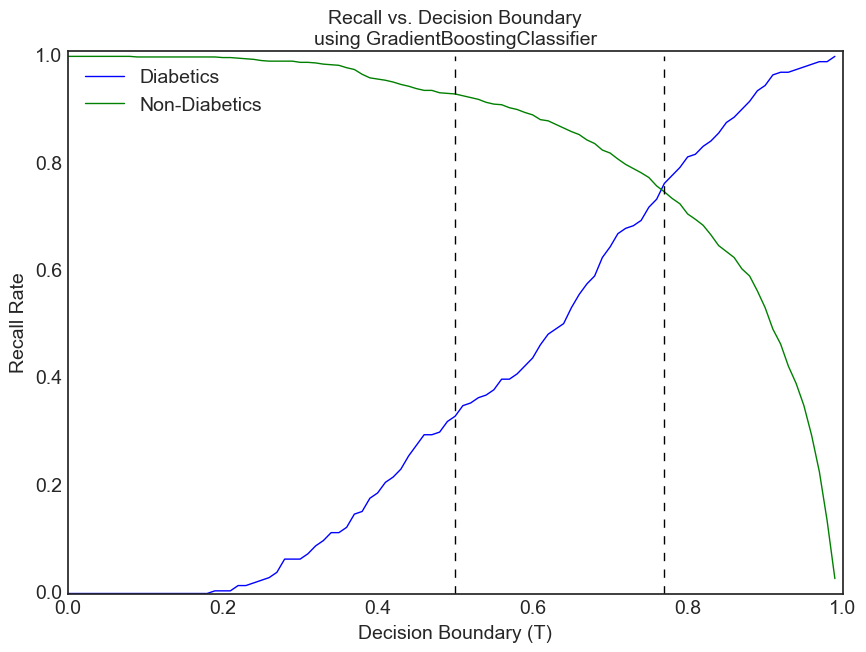

In [19]:
plot_recall_vs_decision_boundary(t_recall_diab, t_recall_nodiab)

### Performance Metrics 

In [20]:
threshold = .5

In [21]:
rf_clf = RandomForestClassifier(**rf_best_params).fit(X_train, y_train)
knn_clf = KNeighborsClassifier(**knn_best_params).fit(X_train, y_train)
lg_clf = LogisticRegression(**lg_best_params).fit(X_train, y_train)
svc_clf = SVC(**svc_best_params).fit(X_train_scale, y_train)

In [22]:
rf_proba  = rf_clf.predict_proba(X_test)
knn_proba = knn_clf.predict_proba(X_test)
lg_proba  = lg_clf.predict_proba(X_test)
svc_proba = svc_clf.predict_proba(X_test_scale)

In [23]:
# Create Ensemble
df_preds = pd.DataFrame({
        'LogisticRegression': lg_proba[:,1],
        'KNeighborsClassifier': knn_proba[:,1],
        'RandomForestClassifier': rf_proba[:,1],
        'GradientBoostingClassifier': gbc_proba[:,1],
        'SVC': svc_proba[:,1]
    })

#df_preds.loc[:,'Ensemble'] = df_preds.mean(axis=1)

In [24]:
for col in df_preds:
    print(col)
    print(metrics.classification_report(y_test, np.where(1 - df_preds.loc[:,col] > threshold, 0, 1)))

GradientBoostingClassifier
             precision    recall  f1-score   support

          0       0.86      0.93      0.89       900
          1       0.52      0.33      0.40       203

avg / total       0.80      0.82      0.80      1103

KNeighborsClassifier
             precision    recall  f1-score   support

          0       0.82      1.00      0.90       900
          1       0.00      0.00      0.00       203

avg / total       0.67      0.82      0.73      1103

LogisticRegression
             precision    recall  f1-score   support

          0       0.86      0.92      0.89       900
          1       0.48      0.33      0.40       203

avg / total       0.79      0.81      0.80      1103

RandomForestClassifier
             precision    recall  f1-score   support

          0       0.83      0.98      0.90       900
          1       0.57      0.12      0.20       203

avg / total       0.78      0.82      0.77      1103

SVC
             precision    recall  f1-score   s

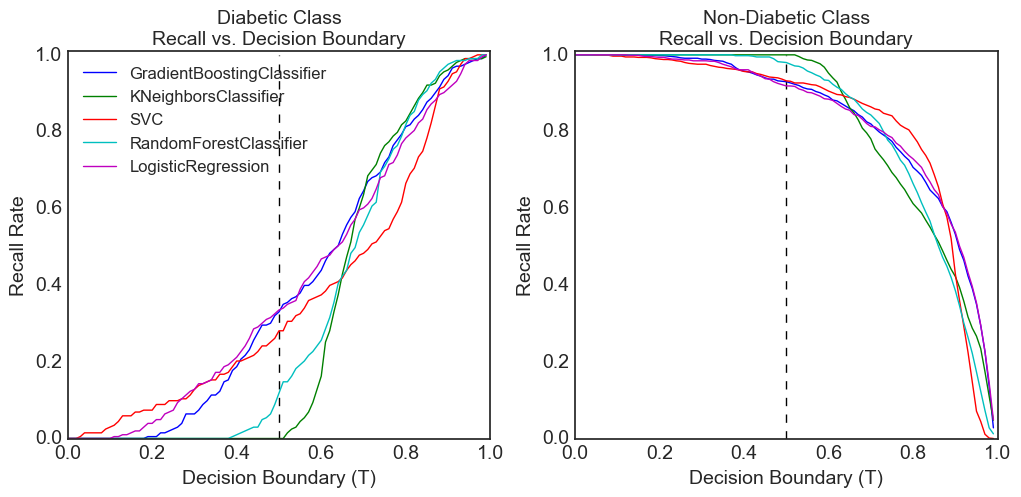

In [25]:
probas = dict(
    GradientBoostingClassifier=gbc_proba,
    KNeighborsClassifier=knn_proba,
    LogisticRegression=lg_proba,
    RandomForestClassifier=rf_proba,
    SVC=svc_proba
)

plot_multi_recall_vs_decision_boundary(probas, y_test)

# ROC Curve

GradientBoostingClassifier
  AUC: 0.827
KNeighborsClassifier
  AUC: 0.794
LogisticRegression
  AUC: 0.817
RandomForestClassifier
  AUC: 0.808
SVC
  AUC: 0.801


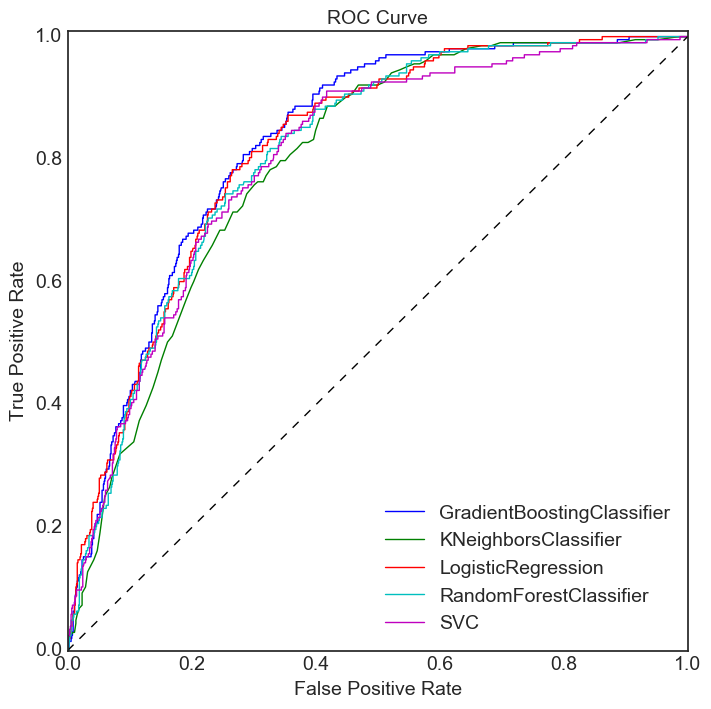

In [26]:
plot_roc_curves(df_preds, y_test)

### Bootstrap ROC Curve for GradientBoostingClassifier

In [27]:
# Warning: bootstraping may take a while
results = bootstrap_model(
    gbc_clf,
    X_train, 
    y_train, 
    X_test, 
    y_test,
    10,   # change the number of bootstraps here
    0.5
)

In [28]:
total_auc = []
for r in results['fpr_tpr']:
    total_auc.append(metrics.auc(r[0], r[1]))

### Bootstrap mean and empirical confidence intervals

In [29]:
np.mean(total_auc)

0.82515270935960583

In [30]:
pd.Series(total_auc).quantile([.025, .975])

0.025    0.820549
0.975    0.832150
dtype: float64

### Bootstrap ROC curve

In [31]:
df_interp = pd.DataFrame(roc_interp(results['fpr_tpr'])).T

In [32]:
m = df_interp.mean(axis=1).values.tolist()
ci = df_interp.quantile([.025, .975], axis=1).values.tolist()

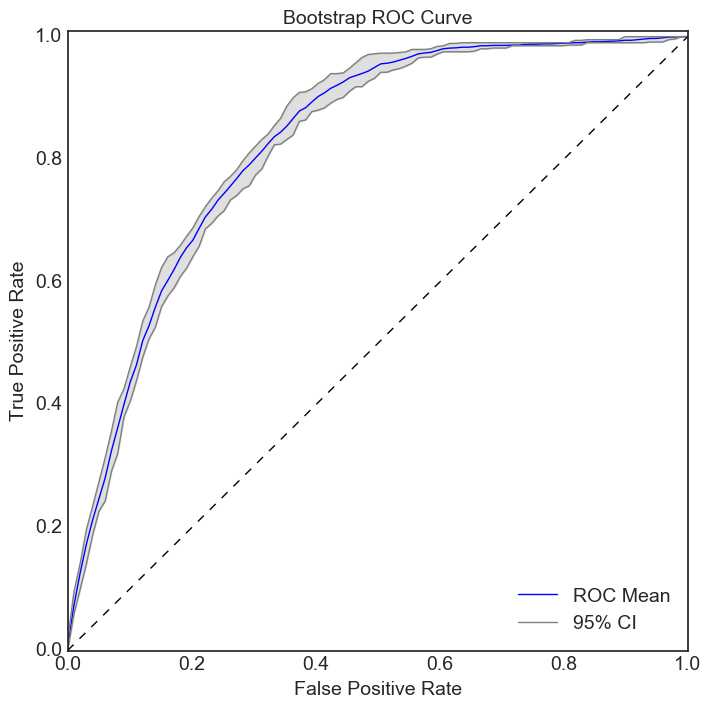

In [33]:
plot_bootstrap_roc(m, ci)